# Técnicas de aprendizaje no supervisado y espectroscopía Raman para descubrir patrones de pigmentación en conchas arqueológicas de moluscos

Trabajo de Fin de Máster para acceder al **Máster en Ciencia de Datos**

Autor: Andrea Pérez Asensio

Director: Adolfo Cobo García

Co-Director: David Cuenca Solana

El objetivo principal de este trabajo es el de analizar espectros Raman de conchas de moluscos para poder estudiar la coloración de las muestras y predecir el color que tuvieron unas conchas arqueológicas que han perdido el color.

En este *Notebook* se recoge todo el código utilizado en el análisis de los espectros Raman.

# 1. Carga de paquetes y de datos
Se realiza la importación de los paquetes utilizados y se cargan los datos. Se realiza un preprocesado que consiste en la etiquetación y concatenación de los datos, obteniendo un *DataFrame* de *pandas* con un multi-índice

In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

print("Todos los paquetes necesarios han sido importados")


Todos los paquetes necesarios han sido importados


## 1.1. Carga de los datos.

Se cargan los datos obtenidos tanto por la Sonda de 532nm como los medidos utilizando el micoscópio Nanobase.
Los CSV que se cargan contienen los espectros preprocesados de las diferentes conchas. Para más información sobre el preprocesado elegido consulte **procesado_nanobase.ipynb** y **procesado_sonda532nm.ipynb**

In [2]:
# Cargamos todos los datasets 
#data_sonda_2023_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
#data_sonda_2024_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
#data_sonda_2024_Python = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoPython.csv', index_col=[0,1,2,3,4,5,6,7])
#data_nanobase = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\\nanobasepreprocesado.csv', index_col=[0])


# data_sonda_2023_Matlab= pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Matlab= pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
# data_sonda_2024_Python= pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2024_preprocesadoPython.csv', index_col=[0,1,2,3,4,5,6,7])

In [21]:
data_nanobase_muestras = data_nanobase.index.get_level_values("Muestra").unique().tolist()
data_nanobase_muestras

['LIT1', 'LIT2', 'LIT3', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT4']

In [3]:
data_sonda_2024_Matlab_muestras = data_sonda_2024_Matlab.index.get_level_values("Muestra").unique().tolist()
#data_sonda_2024_Python_muestras = data_sonda_2024_Python.index.get_level_values("Muestra").unique().tolist()
#data_sonda_2023_Matlab_muestras = data_sonda_2023_Matlab.index.get_level_values("Muestra").unique().tolist()
#data_nanobase_muestras = data_nanobase.index.get_level_values("Muestra").unique().tolist()

print("Las muestras de 2024 en Matlab son: ", data_sonda_2024_Matlab_muestras)
#print("Las muestras de 2024 en Python son: ", data_sonda_2024_Python_muestras)
#print("Las muestras de 2023 en Matlab son: ", data_sonda_2023_Matlab_muestras)
#print("Las muestras de Nanobase son: ", data_nanobase_muestras)


Las muestras de 2024 en Matlab son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT921.1']


In [5]:

# Separamos las muestras LIT7 de 2023 y LIT921 de 2024
#data_sonda_2023_Matlab_LIT7 = data_sonda_2023_Matlab.loc[data_sonda_2023_Matlab.index.get_level_values("Muestra") == 'LIT7']
#data_sonda_2024_Python_LIT921_1 = data_sonda_2024_Python.loc[data_sonda_2024_Python.index.get_level_values("Muestra") == 'LIT921.1']
#data_sonda_2024_Matlab_LIT921#_2 = data_sonda_2024_Matlab.loc[data_sonda_2024_Matlab.index.get_level_values("Muestra") == 'LIT921.1']

# Eliminamos las muestras LIT7 de 2023 y LIT921 de 2024
#data_sonda_2023_Matlab = data_sonda_2023_Matlab.loc[data_sonda_2023_Matlab.index.get_level_values("Muestra") != 'LIT7']
#print("Las nuevas muestras de 2023 en Matlab son: ", data_sonda_2023_Matlab.index.get_level_values("Muestra").unique().tolist())
data_sonda_2024_Matlab = data_sonda_2024_Matlab.loc[data_sonda_2024_Matlab.index.get_level_values("Muestra") != 'LIT921.1']
print("Las nuevas muestras de 2024 en Matlab son: ", data_sonda_2024_Matlab.index.get_level_values("Muestra").unique().tolist())
#data_sonda_2024_Python = data_sonda_2024_Python.loc[data_sonda_2024_Python.index.get_level_values("Muestra") != 'LIT921.1']
#print("Las nuevas muestras de 2024 en Python son: ", data_sonda_2024_Python.index.get_level_values("Muestra").unique().tolist())


# Guarmados los datasets sin las muestras LIT7 de 2023 y LIT921 de 2024
#data_sonda_2023_Matlab_LIT7.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_LIT7_preprocesadoMatlab.csv', index=True)

Las nuevas muestras de 2024 en Matlab son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']


# 2. Estudio de los espectros
## 2.1. Comparativa espectros medios
Se realiza una comparativa sobre los datos medidos utilizando la Sonda Raman en 2023 y 2024. En las siguientes gráficas se representan los espectros medios de cada muestra normalizados y sin normalizar. En el espectro no normalizado se puede observar la diferencia entre las intensidades de la señal, mientras que en normalizado se puede estudiar el ruido.

In [6]:
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3','LIT885.1']

def avg_spectrum_all_8muestras_comp(data1, data2,  muestras):
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))

    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        # Datos para 2023
        data_muestra1 = data1[data1.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber1 = data_muestra1.columns.get_level_values(0).astype(float)
        mean_intensity1 = data_muestra1.mean(axis=0)

        # Datos para 2024
        data_muestra2 = data2[data2.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber2 = data_muestra2.columns.get_level_values(0).astype(float)
        mean_intensity2 = data_muestra2.mean(axis=0)
        
        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber1, mean_intensity1, label=f'2023 Matlab')
        axes[fila, columna].plot(wavenumber2, mean_intensity2, label=f'2024 Matlab')
        
        axes[fila, columna].set_xlabel('Raman Shift (cm$^{-1}$)')
        axes[fila, columna].set_ylabel('Intensity (a.u.)')
        axes[fila, columna].set_title(f'Muestra {muestra}')

        axes[fila, columna].legend()

    # Ajusta el espaciado entre subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()

def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

data_sonda_2024_Matlab_snv = SNV(data_sonda_2024_Matlab)
#data_sonda_2024_Python_snv = SNV(data_sonda_2024_Python)
#data_sonda_2023_Matlab_snv = SNV(data_sonda_2023_Matlab)

print('Espectros medios para las muestras normalizados con SNV')
#avg_spectrum_all_8muestras_comp( data_sonda_2024_Matlab_snv, data_sonda_2023_Matlab_snv, muestras_ordenadas)
print('Espectros medios para las muestras sin normalizar')
#avg_spectrum_all_8muestras_comp( data_sonda_2024_Matlab,data_sonda_2023_Matlab, muestras_ordenadas)


Espectros medios para las muestras normalizados con SNV
Espectros medios para las muestras sin normalizar


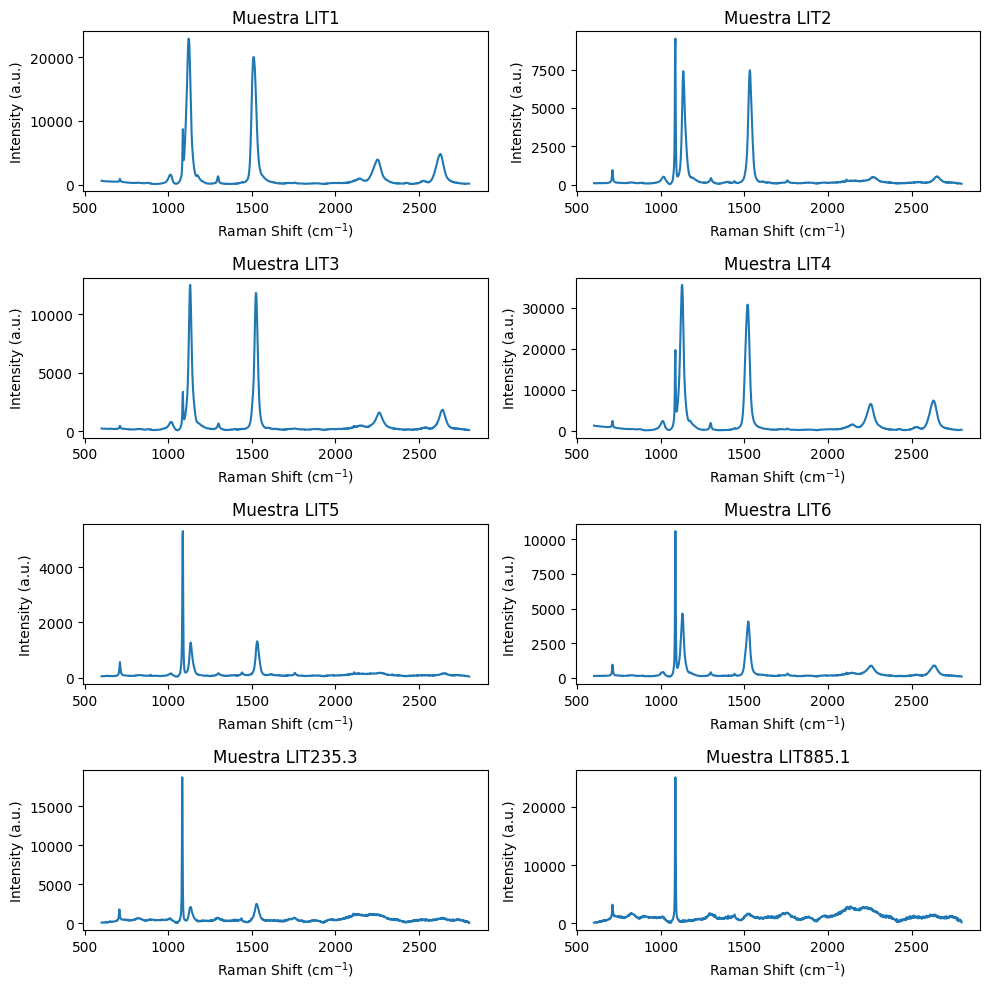

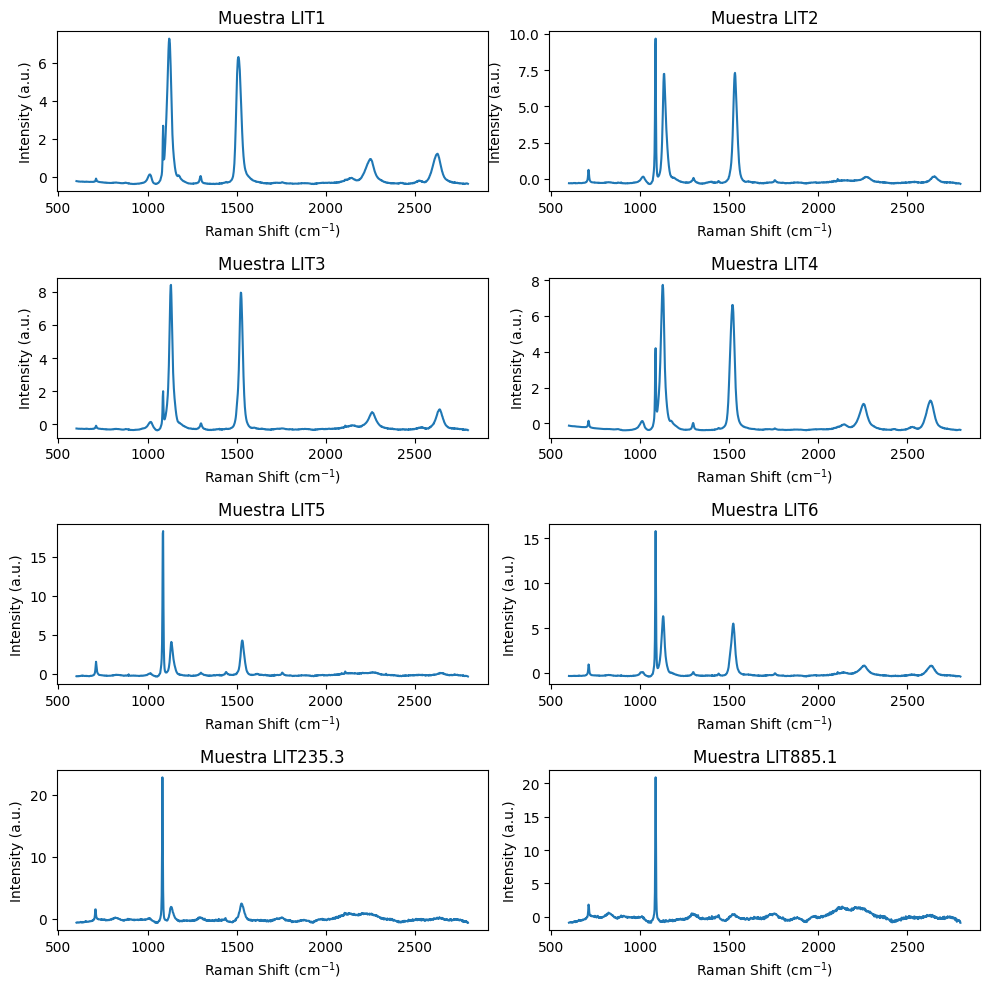

In [25]:
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4','LIT5','LIT6','LIT235.3', 'LIT885.1']
def avg_spectrum_all(data,  muestras):
    #data = pd.concat(dataframes, axis=0)
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))
    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber = data_muestra.columns.get_level_values(0).astype(float)
        # Calcula las intensidades medias para cada número de onda
        mean_intensity = data_muestra.mean(axis=0)


        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber, mean_intensity, label=f'Muestra {muestra}')
        axes[fila, columna].set_xlabel('Raman Shift (cm$^{-1}$)')
        axes[fila, columna].set_ylabel('Intensity (a.u.)')
        axes[fila, columna].set_title(f'Muestra {muestra}')


    # Ajusta el espaciado entre subplots
    plt.tight_layout()
    


    # Muestra los subplots
    plt.show()

avg_spectrum_all(data_nanobase, muestras_ordenadas)
data_nanobase_snv = SNV(data_nanobase)
avg_spectrum_all(data_nanobase_snv, muestras_ordenadas)

# 3. Clusterización



## 3.1. Elección del número de clusters.
Para la elección del número de clusters utilizamos el método del codo

In [26]:
from scipy.cluster.hierarchy import linkage
def elbow_method (data, k_values, metodo_clustering, titulo):
     wcss = [] # Suma de los cuadrados de la distancia
     if metodo_clustering == 'K-Means':
           for k in k_values:
                model = KMeans(n_clusters=k)
                model.fit(data)
                wcss.append(model.inertia_)
                # La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide 
                # de su cluster asignado y sumando estos 
                # valores para todos los clusters. 
                # Esencialmente, mide la dispersión dentro de cada cluster.
     elif metodo_clustering == 'Agglomerative':
           for k in k_values:
                model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
                labels = model.fit_predict(data)
                linkage_matrix = linkage(data, method='ward')
                wcss.append(sum([d**2 for d in linkage_matrix[:, 2]]))
                #La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide
                #  del cluster final al que pertenece. La matriz de enlace se utiliza para
                #  determinar a qué cluster final se asigna cada punto.
     else:
        raise ValueError("Método de clustering no válido. Use 'K-Means' o 'Agglomerative'.")
        return
     

    # Graficar el método del codo
     plt.plot(k_values, wcss, marker='o')
     plt.xlabel('Número de Clusters (K)')
     plt.ylabel('WCSS')
     plt.title(titulo)

warnings.filterwarnings("ignore")

In [27]:
# elbow_method(data_sonda_2024_Matlab, range(1,15),"K-Means", 'Método del codo utilizando el dataset 2024 Matlab')


In [28]:
# elbow_method(data_sonda_2024_Python, range(1,15),"K-Means", 'Método del codo utilizando el dataset 2024 Python')

Atendiendo a la gráfica representada anteriormente podemos observar que el número óptimo de clústers sería entorno a 5-6, ya que es en ese punto cuando la curva empieza a aplanarse

In [29]:
# elbow_method(data_sonda_2023_Matlab, range(1,15),"K-Means", 'Método del codo utilizando el dataset 2023 Matlab')

En esta gráfica podemos apreciar que el valor en el que empeiza a planarse se acerca más a 7-8

In [30]:
# elbow_method(data_nanobase, range(1,15),"K-Means", 'Método del codo utilizando el dataset Nanobase')

## 3.2 Aplicación de clusterings

In [7]:
def plot_clusters_class_8muestras_4col(data, muestras, tipo_cluster="Cluster_KMeans", color_tipo='#1f77b4', title = "K-Means Clustering para Nanobase"):

    # Crear subplots con el diseño deseado
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())
    indices_cluster = np.arange(len(todos_clusters))

    # Realizamos para cada muestra
    for i, muestra in enumerate(muestras):
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]

        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)

        # Creamos un barplot
        fila = i % 2
        columna = i // 2

        # Verificamos si la muestra es "Arq 235" o "Arq 885" para cambiar el color a rojo
        color_actual = 'red' if muestra in [ 'LIT235.3', 'LIT885.1'] else color_tipo
        bar_cluster = axes[fila, columna].bar(indices_cluster, cluster_counts, width=0.9, label=tipo_cluster, color=color_actual)

        # Editamos el título para cada muestra:
        axes[fila, columna].set_title(f"{muestra}")
        axes[fila, columna].set_xticks(indices_cluster)
        axes[fila, columna].set_xticklabels(todos_clusters)
        axes[fila, columna].set_xlabel("Cluster")
        axes[fila, columna].set_ylabel("Number of Spectra")

    # Añado un título
    fig.suptitle(title)

    # Ajustar espaciado entre subplots
    plt.tight_layout()



    plt.show()

### 3.2.1. K-Means

In [9]:
def clustering_K_Means(data, n_clusters):
    """
    Realiza clustering K-Means sobre el dataset proporcionado.
    :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
    :parameter *n_clusters*: número de clusters a utilizar.
    :return: modelo de clustering K-Means entrenado.
    """
    t1 = time.time()
    kmeans = KMeans(n_clusters = n_clusters, random_state = 50).fit(data)
    data["Cluster_KMeans"] = kmeans.labels_
    # Convertir la columna Cluster_KMeans en un MultiIndex
    multiindex = pd.MultiIndex.from_frame(data[['Cluster_KMeans']])
    # Añadir el nuevo nivel de índice al multiíndice existente
    data = data.set_index(multiindex, append=True)
    data = data.drop(columns=['Cluster_KMeans'])
    t2 = time.time()
    tiempo = t2 - t1
    return data, tiempo


data_sonda_2024_Matlab_copy = data_sonda_2024_Matlab.copy()
#data_sonda_2023_Matlab_copy = data_sonda_2023_Matlab.copy()
#data_sonda_2024_Python_copy = data_sonda_2024_Python.copy()
#data_nanobase_copy = data_nanobase.copy()

data_sonda_2024_Matlab_copy, tiempo_2024_Matlab_KMeans = clustering_K_Means(data_sonda_2024_Matlab_copy, 5)
# data_sonda_2023_Matlab_copy, tiempo_2023_Matlab_KMeans = clustering_K_Means(data_sonda_2023_Matlab_copy, 7)
# data_sonda_2024_Python_copy, tiempo_2024_Python_Kmeans = clustering_K_Means(data_sonda_2024_Python_copy, 5)
# data_nanobase_copy, tiempo_nanobase_KMeans = clustering_K_Means(data_nanobase_copy, 5)

print(f"Tiempo de ejecución de clustering K-Means para dataset de 2024 Matlab: {tiempo_2024_Matlab_KMeans:.2f} segundos")
# print(f"Tiempo de ejecución de clustering K-Means para dataset de 2023 Matlab: {tiempo_2023_Matlab_KMeans:.2f} segundos")
# print(f"Tiempo de ejecución de clustering K-Means para dataset de 2024 Python: {tiempo_2024_Python_Kmeans:.2f} segundos")
# print(f"Tiempo de ejecución de clustering K-Means para dataset de Nanobase: {tiempo_nanobase_KMeans:.2f} segundos")


/opt/homebrew/Caskroom/miniforge/base/envs/TFM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Tiempo de ejecución de clustering K-Means para dataset de 2024 Matlab: 1.60 segundos


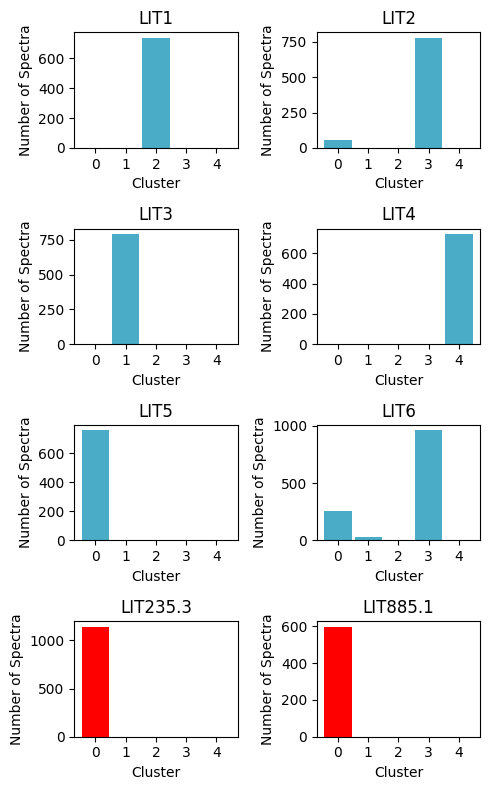

In [11]:
def plot_clusters_class_8muestras_2col(data, muestras, tipo_cluster='Cluster_KMeans', title= 'Distribución de los Clústers en las 8 muestras', color_tipo = '#1f77b4'):

    # Crear subplots con el diseño deseado
    fig, axes = plt.subplots(4, 2, figsize=(5, 8))


    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())

    indices_cluster = np.arange(len(todos_clusters))

    # Realizamos para cada muestra
    for i, muestra in enumerate(muestras):
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]

        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)
        color_actual = 'red' if muestra in [ 'LIT235.3', 'LIT885.1'] else color_tipo
        # Creamos un barplot
        row = i // 2
        col = i % 2
        axes[row, col].bar(indices_cluster, cluster_counts, width=0.9, label=tipo_cluster, color = color_actual)
        
        # Editamos el título para cada muestra
        axes[row, col].set_title(f"{muestra}")
        axes[row, col].set_xticks(indices_cluster)
        axes[row, col].set_xticklabels(todos_clusters)
        axes[row, col].set_xlabel("Cluster")
        axes[row, col].set_ylabel("Number of Spectra")


    # Añado un título general
    # fig.suptitle(title)

    # Ajustar espaciado entre subplots
    plt.tight_layout()
    plt.show()

muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3','LIT885.1']

plot_clusters_class_8muestras_2col(data_sonda_2024_Matlab_copy, muestras_ordenadas,'Cluster_KMeans', title = "K-Means Clustering para 2024 Matlab", color_tipo = "#4AACC6" )
# plot_clusters_class_8muestras_2col(data_sonda_2023_Matlab_copy, muestras_ordenadas,'Cluster_KMeans', title = "K-Means Clustering para 2023 Matlab")
# plot_clusters_class_8muestras_2col(data_sonda_2024_Python_copy, muestras_ordenadas,'Cluster_KMeans', title = "K-Means Clustering para 2024 Python")
# plot_clusters_class_8muestras_2col(data_nanobase_copy, muestras_ordenadas,'Cluster_KMeans', title = "K-Means Clustering para Nanobase")


# plot_clusters_class_8muestras_4col(data_sonda_2024_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para 2024 Matlab")
# plot_clusters_class_8muestras_4col(data_sonda_2023_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para 2023 Matlab")
# plot_clusters_class_8muestras_4col(data_sonda_2024_Python_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para 2024 Python")
# plot_clusters_class_8muestras_4col(data_nanobase_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para Nanobase")

#### Correlación

In [ ]:

def calculo_correlacion(data, muestras, tipo_cluster = 'Cluster_KMeans'):
    frecuencias = []
    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())

    # Realizamos para cada muestra
    for muestra in muestras:
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]
        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values('Cluster_KMeans').value_counts().reindex(todos_clusters, fill_value=0)
        frecuencias.append(cluster_counts)

    # Calcular la media de cada vector
    medias = [np.mean(frec) for frec in frecuencias]

    # Calcular la matriz de correlación
    matriz_correlacion = np.corrcoef(frecuencias)

    # Crear una tabla para almacenar las correlaciones de Pearson
    correlaciones = []

    for i, muestra in enumerate(muestras[:-2]):
        correlacion_8 = np.corrcoef(frecuencias[i], frecuencias[-1])[0, 1]
        correlacion_7 = np.corrcoef(frecuencias[i], frecuencias[-2])[0, 1]
        correlaciones.append([muestra, correlacion_7, correlacion_8])

    # Convertir la lista de correlaciones en un DataFrame de pandas
    df_correlaciones = pd.DataFrame(correlaciones, columns=["Muestra", "Correlación con Muestra 7", "Correlación con Muestra 8"])

    # Encontrar la correlación más alta con las muestras 7 y 8
    max_correlacion_7 = df_correlaciones["Correlación con Muestra 7"].max()
    muestra_max_corr_7 = df_correlaciones.loc[df_correlaciones["Correlación con Muestra 7"].idxmax(), "Muestra"]
    
    max_correlacion_8 = df_correlaciones["Correlación con Muestra 8"].max()
    muestra_max_corr_8 = df_correlaciones.loc[df_correlaciones["Correlación con Muestra 8"].idxmax(), "Muestra"]

    # Imprimir las correlaciones más altas
    print(f"La correlación más alta con la Muestra 7 es {max_correlacion_7:.2f}, con la Muestra: {muestra_max_corr_7}")
    print(f"La correlación más alta con la Muestra 8 es {max_correlacion_8:.2f}, con la Muestra: {muestra_max_corr_8}")

    return matriz_correlacion, df_correlaciones

In [ ]:

# Ejemplo de uso
print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab")
data = data_sonda_2024_Matlab_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Matlab_KMeans = calculo_correlacion(data, muestras)
print(df_correlaciones_2024_Matlab_KMeans)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
data = data_sonda_2023_Matlab_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2023_Matlab_KMeans = calculo_correlacion(data, muestras)
print(df_correlaciones_2023_Matlab_KMeans)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Python")
data = data_sonda_2024_Python_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Python_KMeans = calculo_correlacion(data, muestras)
print(df_correlaciones_2024_Python_KMeans)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de Nanobase")
data = data_nanobase_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_nanobase_KMeans = calculo_correlacion(data, muestras)
print(df_correlaciones_nanobase_KMeans)

Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab
La correlación más alta con la Muestra 7 es 1.00, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 1.00, con la Muestra: LIT5
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                  -0.250000                  -0.250000
1    LIT2                  -0.184698                  -0.184698
2    LIT3                  -0.250791                  -0.250791
3    LIT4                  -0.250000                  -0.250000
4    LIT5                   0.999999                   0.999999
5    LIT6                   0.011126                   0.011126
Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab
La correlación más alta con la Muestra 7 es 0.85, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 0.80, con la Muestra: LIT2
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                   0.0468

### 3.2.2. Agglomerative



In [12]:
def clustering_AHC(data, n_clusters):
    """
    Realiza clustering AHC sobre el dataset proporcionado.
    :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
    :parameter *n_clusters*: número de clusters a utilizar.
    :return: modelo de clustering K-Means entrenado.
    """
    t1 = time.time()
    agg_clustering = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean', linkage='ward')
    data["Cluster_AHC"] = agg_clustering.fit_predict(data)
    # Convertir la columna Cluster_AHC en un MultiIndex
    multiindex = pd.MultiIndex.from_frame(data[['Cluster_AHC']])
    # Añadir el nuevo nivel de índice al multiíndice existente
    data = data.set_index(multiindex, append=True)
    data = data.drop(columns=['Cluster_AHC'])
    t2 = time.time()
    tiempo = t2 - t1
    return data, tiempo


data_sonda_2024_Matlab_copy, tiempo_2024_Matlab_AHC = clustering_AHC(data_sonda_2024_Matlab_copy, 5)
# data_sonda_2023_Matlab_copy, tiempo_2023_Matlab_AHC = clustering_AHC(data_sonda_2023_Matlab_copy, 7)
# data_sonda_2024_Python_copy, tiempo_2024_Python_AHC = clustering_AHC(data_sonda_2024_Python_copy, 5)
# data_nanobase_copy, tiempo_nanobase_AHC = clustering_AHC(data_nanobase_copy, 5)

print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Matlab: {tiempo_2024_Matlab_AHC:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2023 Matlab: {tiempo_2023_Matlab_AHC:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Python: {tiempo_2024_Python_AHC:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de Nanobase: {tiempo_nanobase_AHC:.2f} segundos")

/opt/homebrew/Caskroom/miniforge/base/envs/TFM/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Tiempo de ejecución de clustering AHC para dataset de 2024 Matlab: 8.54 segundos


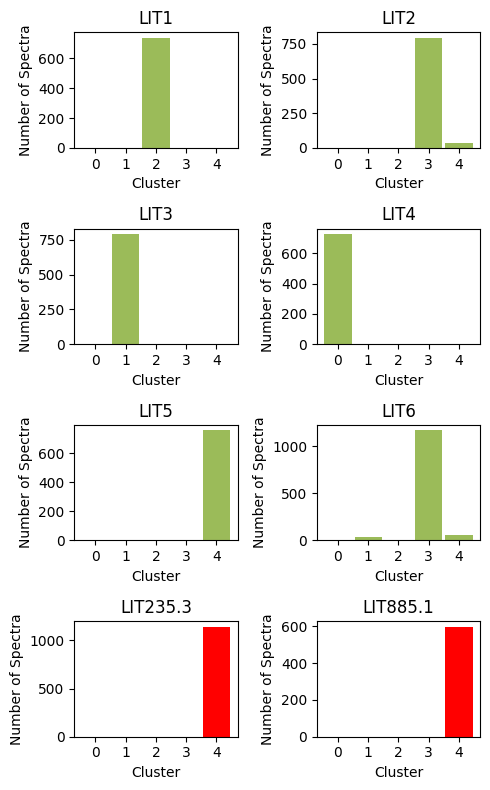

In [13]:
plot_clusters_class_8muestras_2col(data_sonda_2024_Matlab_copy, muestras_ordenadas,'Cluster_AHC', title = "AHC Clustering para 2024 Matlab", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_2col(data_sonda_2023_Matlab_copy, muestras_ordenadas,'Cluster_AHC', title = "AHC Clustering para 2023 Matlab", color_tipo = "#2ca02c")
# plot_clusters_class_8muestras_2col(data_sonda_2024_Python_copy, muestras_ordenadas,'Cluster_AHC', title = "AHC Clustering para 2024 Python", color_tipo = "#1EB440")
# plot_clusters_class_8muestras_2col(data_nanobase_copy, muestras_ordenadas,'Cluster_AHC', title = "AHC Clustering para Nanobase", color_tipo = "#1EB440")

# plot_clusters_class_8muestras_4col(data_sonda_2024_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para 2024 Matlab", color_tipo = "#1EB440")
# plot_clusters_class_8muestras_4col(data_sonda_2023_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para 2023 Matlab", color_tipo = "#1EB440")
# plot_clusters_class_8muestras_4col(data_sonda_2024_Python_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para 2024 Python", color_tipo = "#1EB440")
# plot_clusters_class_8muestras_4col(data_nanobase_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para Nanobase", color_tipo = "#1EB440")


#### Correlacion

In [21]:
# Ejemplo de uso
print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab")
data = data_sonda_2024_Matlab_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Matlab_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
print(df_correlaciones_2024_Matlab_AHC)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
data = data_sonda_2023_Matlab_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2023_Matlab_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
print(df_correlaciones_2023_Matlab_AHC)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Python")
data = data_sonda_2024_Python_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Python_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
print(df_correlaciones_2024_Python_AHC)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de Nanobase")
data = data_nanobase_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_nanobase_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
print(df_correlaciones_nanobase_AHC)

Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab
La correlación más alta con la Muestra 7 es 1.00, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 1.00, con la Muestra: LIT5
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                  -0.250000                  -0.250000
1    LIT2                  -0.184698                  -0.184698
2    LIT3                  -0.250791                  -0.250791
3    LIT4                  -0.250000                  -0.250000
4    LIT5                   0.999999                   0.999999
5    LIT6                   0.011126                   0.011126
Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab
La correlación más alta con la Muestra 7 es 0.85, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 0.80, con la Muestra: LIT2
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                   0.0468

### 3.2.4 BIRCH

In [14]:
def clustering_BIRCH(data, n_clusters):
    """
    Realiza clustering BIRCH sobre el dataset proporcionado.
    :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
    :parameter *n_clusters*: número de clusters a utilizar.
    :return: modelo de clustering K-Means entrenado.
    """
    t1 = time.time()
    birch_clustering =  Birch(threshold=0.01, n_clusters= n_clusters)
    data["Cluster_BIRCH"] = birch_clustering.fit_predict(data)
    # Convertir la columna Cluster_BIRCH en un MultiIndex
    multiindex = pd.MultiIndex.from_frame(data[['Cluster_BIRCH']])
    # Añadir el nuevo nivel de índice al multiíndice existente
    data = data.set_index(multiindex, append=True)
    data = data.drop(columns=['Cluster_BIRCH'])
    t2 = time.time()
    tiempo = t2 - t1
    return data, tiempo

In [15]:
data_sonda_2024_Matlab_copy, tiempo_2024_Matlab_BIRCH = clustering_BIRCH(data_sonda_2024_Matlab_copy, 5)
# data_sonda_2023_Matlab_copy, tiempo_2023_Matlab_BIRCH = clustering_BIRCH(data_sonda_2023_Matlab_copy, 7)
# data_sonda_2024_Python_copy, tiempo_2024_Python_BIRCH = clustering_BIRCH(data_sonda_2024_Python_copy, 5)
# data_nanobase_copy, tiempo_nanobase_BIRCH = clustering_BIRCH(data_nanobase_copy, 5)

# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Matlab: {tiempo_2024_Matlab_BIRCH:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2023 Matlab: {tiempo_2023_Matlab_BIRCH:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Python: {tiempo_2024_Python_BIRCH:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de Nanobase: {tiempo_nanobase_BIRCH:.2f} segundos")

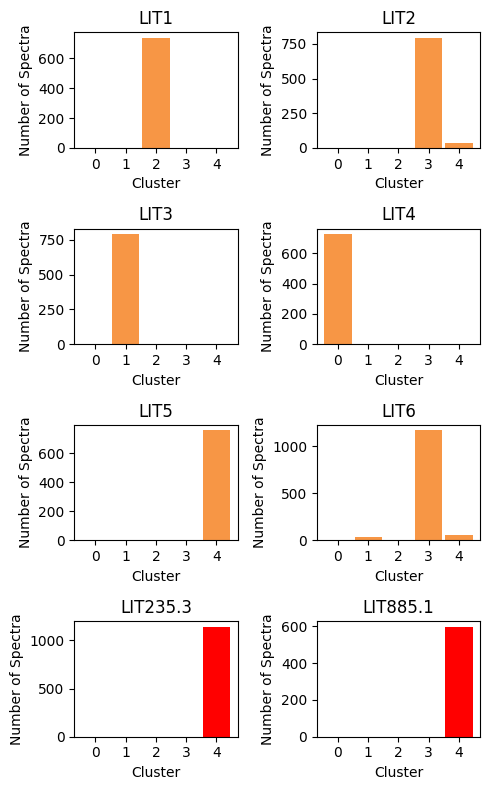

In [16]:
plot_clusters_class_8muestras_2col(data_sonda_2024_Matlab_copy, muestras_ordenadas,'Cluster_BIRCH', title = "BIRCH Clustering para 2024 Matlab", color_tipo = "#F79645")
# plot_clusters_class_8muestras_2col(data_sonda_2023_Matlab_copy, muestras_ordenadas,'Cluster_BIRCH', title = "BIRCH Clustering para 2023 Matlab", color_tipo = "#ff7f0e")
# plot_clusters_class_8muestras_2col(data_sonda_2024_Python_copy, muestras_ordenadas,'Cluster_BIRCH', title = "BIRCH Clustering para 2024 Python", color_tipo = "#ff7f0e")
# plot_clusters_class_8muestras_2col(data_nanobase_copy, muestras_ordenadas,'Cluster_BIRCH', title = "BIRCH Clustering para Nanobase", color_tipo = "#FFCC79")

# plot_clusters_class_8muestras_4col(data_sonda_2024_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para 2024 Matlab", color_tipo = "#FFCC79")
# plot_clusters_class_8muestras_4col(data_sonda_2023_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para 2023 Matlab", color_tipo = "#FFCC79")
# plot_clusters_class_8muestras_4col(data_sonda_2024_Python_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para 2024 Python", color_tipo = "#FFCC79")
# plot_clusters_class_8muestras_4col(data_nanobase_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para Nanobase", color_tipo = "#FFCC79")



In [25]:
# Ejemplo de uso
print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab")
data = data_sonda_2024_Matlab_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Matlab_BIRCH = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
print(df_correlaciones_2024_Matlab_BIRCH)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
data = data_sonda_2023_Matlab_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2023_Matlab_BIRCH = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
print(df_correlaciones_2023_Matlab_BIRCH)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Python")
data = data_sonda_2024_Python_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Python_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
print(df_correlaciones_2024_Python_AHC)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de Nanobase")
data = data_nanobase_copy
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_nanobase_BIRCH = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
print(df_correlaciones_nanobase_BIRCH)

Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab
La correlación más alta con la Muestra 7 es 1.00, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 1.00, con la Muestra: LIT5
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                  -0.250000                  -0.250000
1    LIT2                  -0.184698                  -0.184698
2    LIT3                  -0.250791                  -0.250791
3    LIT4                  -0.250000                  -0.250000
4    LIT5                   0.999999                   0.999999
5    LIT6                   0.011126                   0.011126
Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab
La correlación más alta con la Muestra 7 es 0.85, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 0.80, con la Muestra: LIT2
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                   0.0468

# Extra


## PCA

Número de componentes principales necesarios para explicar al menos el 95.0% de la varianza: 334


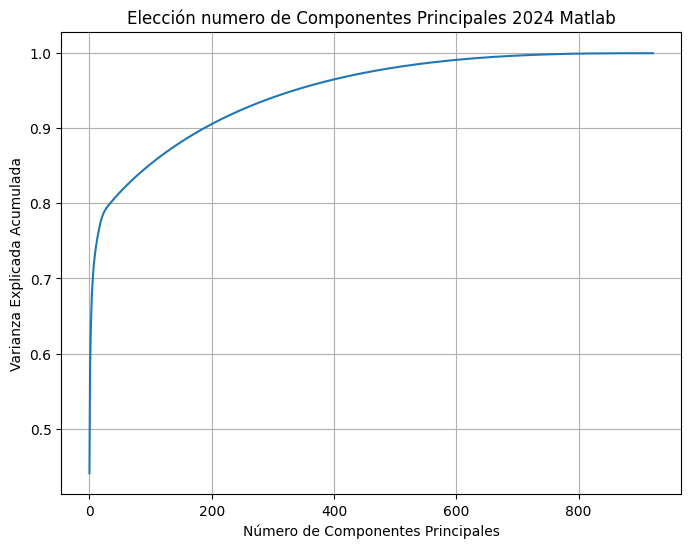

In [26]:
# Escalamos los datos
scaler = StandardScaler()
data_scaled_2024_Matlab_snv = scaler.fit_transform(data_sonda_2024_Matlab_snv)

# Aplicamos PCA
pca_2024_Matlab_snv = PCA()
data_pca_2024_Matlab_snv = pca_2024_Matlab_snv.fit_transform(data_scaled_2024_Matlab_snv)

# Calcular la varianza explicada por cada componente
explained_variance_2024_Matlab_snv = pca_2024_Matlab_snv.explained_variance_ratio_
# Calcular la varianza acumulada
cumulative_variance = np.cumsum(explained_variance_2024_Matlab_snv)

# Establecer el umbral de varianza explicada
threshold = 0.95

# Encontrar el número de componentes necesarios para superar el umbral
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Número de componentes principales necesarios para explicar al menos el {threshold*100}% de la varianza: {num_components}")


# Graficar la varianza explicada acumulada en función del número de componentes
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_2024_Matlab_snv))
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Elección numero de Componentes Principales 2024 Matlab")
plt.grid(True)
plt.show()

Número de componentes principales necesarios para explicar al menos el 95.0% de la varianza: 565


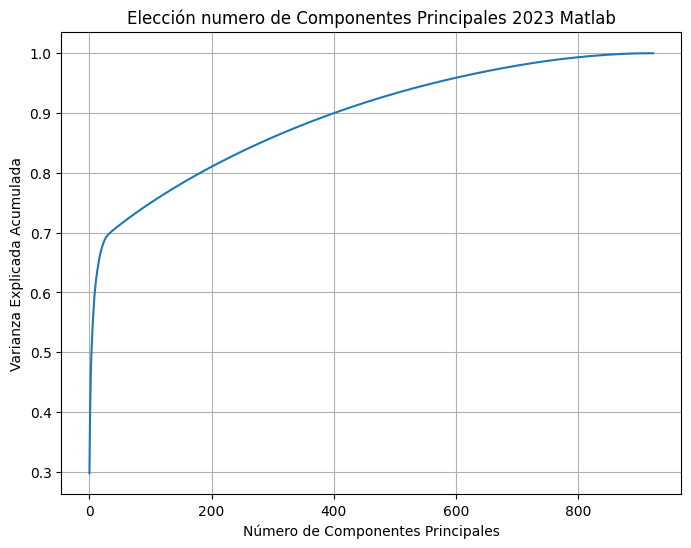

In [27]:
# Escalamos los datos
scaler = StandardScaler()
data_scaled_2023_Matlab_snv = scaler.fit_transform(data_sonda_2023_Matlab_snv)

# Aplicamos PCA
pca_2023_Matlab_snv = PCA()
data_pca_2023_Matlab_snv = pca_2023_Matlab_snv.fit_transform(data_scaled_2023_Matlab_snv)

# Calcular la varianza explicada por cada componente
explained_variance_2023_Matlab_snv = pca_2023_Matlab_snv.explained_variance_ratio_
# Calcular la varianza acumulada
cumulative_variance = np.cumsum(explained_variance_2023_Matlab_snv)

# Establecer el umbral de varianza explicada
threshold = 0.95

# Encontrar el número de componentes necesarios para superar el umbral
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Número de componentes principales necesarios para explicar al menos el {threshold*100}% de la varianza: {num_components}")


# Graficar la varianza explicada acumulada en función del número de componentes
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_2023_Matlab_snv))
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Elección numero de Componentes Principales 2023 Matlab")
plt.grid(True)
plt.show()

Número de componentes principales necesarios para explicar al menos el 95.0% de la varianza: 7


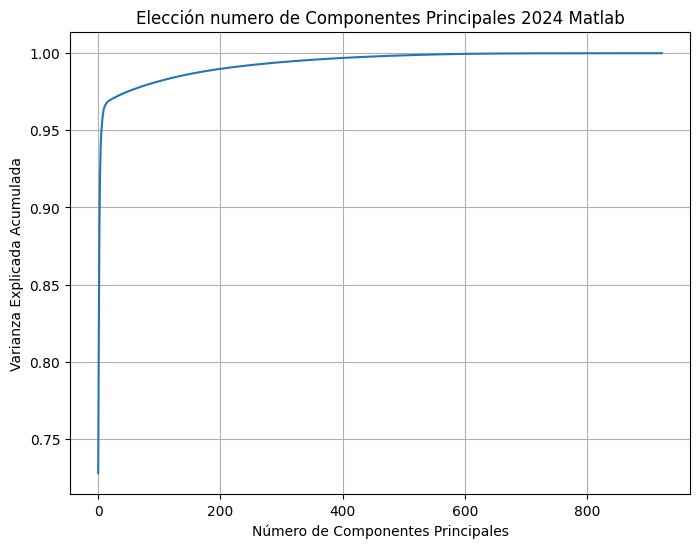

In [28]:
# Escalamos los datos
scaler = StandardScaler()
data_scaled_2024_Python_snv = scaler.fit_transform(data_sonda_2024_Python_snv)

# Aplicamos PCA
pca_2024_Python_snv = PCA()
data_pca_2024_Python_snv = pca_2024_Python_snv.fit_transform(data_scaled_2024_Python_snv)

# Calcular la varianza explicada por cada componente
explained_variance_2024_Python_snv = pca_2024_Python_snv.explained_variance_ratio_

# Calcular la varianza acumulada
cumulative_variance = np.cumsum(explained_variance_2024_Python_snv)

# Establecer el umbral de varianza explicada
threshold = 0.95

# Encontrar el número de componentes necesarios para superar el umbral
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Número de componentes principales necesarios para explicar al menos el {threshold*100}% de la varianza: {num_components}")


# Graficar la varianza explicada acumulada en función del número de componentes
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_2024_Python_snv))
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Elección numero de Componentes Principales 2024 Matlab")
plt.grid(True)
plt.show()

In [29]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# Supongamos que tus datos son las siguientes matrices de características:
# X es un array con 8 muestras
X = np.array([
    [1, 2], [1, 4], [1, 0], 
    [10, 2], [10, 4], [10, 0],
    [5, 5], [6, 6]  # Estas son las dos muestras que quieres predecir
])

# Separar las muestras conocidas de las muestras a predecir
X_known = X[:6]
X_predict = X[6:]

# Aplicar KMeans a todas las muestras
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# Asignaciones de clusters
labels = kmeans.labels_

# Obtener los centroides de los clusters
centroids = kmeans.cluster_centers_

# Ver en qué clusters caen las muestras que quieres predecir
predict_labels = kmeans.predict(X_predict)

# Para cada muestra a predecir, encontrar la muestra más cercana en su cluster
for i, pred_label in enumerate(predict_labels):
    # Filtrar las muestras del mismo cluster
    cluster_indices = np.where(labels == pred_label)[0]
    known_cluster_indices = cluster_indices[cluster_indices < 6]  # Excluir las muestras a predecir

    # Calcular la distancia euclidiana entre la muestra a predecir y las muestras en el mismo cluster
    distances = euclidean_distances([X_predict[i]], X[known_cluster_indices]).flatten()

    # Encontrar el índice de la muestra más cercana
    closest_index = known_cluster_indices[np.argmin(distances)]
    
    print(f"La muestra {X_predict[i]} es más similar a la muestra {X[closest_index]}")


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by check_pairwise_arrays.

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Distribuciones de clusters (basadas en la imagen proporcionada)
distributions = {
    'LIT1': np.array([1000, 2000, 0, 0, 6000, 1000, 0]),
    'LIT2': np.array([300, 0, 0, 400, 100, 0, 0]),
    'LIT3': np.array([50, 0, 0, 300, 0, 0, 300]),
    'LIT4': np.array([200, 0, 0, 800, 0, 0, 0]),
    'LIT5': np.array([100, 0, 600, 0, 0, 0, 0]),
    'LIT6': np.array([0, 0, 0, 4000, 0, 0, 4000]),
    'LIT235.3': np.array([10, 0, 300, 250, 0, 0, 0]),
    'LIT885.1': np.array([1000, 0, 0, 6000, 200, 0, 100])
}

# Calcular similitudes usando el coeficiente de correlación de Pearson
similarities = {}

for pred in ['LIT235.3', 'LIT885.1']:
    similarities[pred] = {}
    for known in ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6']:
        corr, _ = pearsonr(distributions[pred], distributions[known])
        similarities[pred][known] = corr

# Mostrar los resultados
for pred in similarities:
    print(f"Similitudes para {pred}:")
    for known, corr in similarities[pred].items():
        print(f"  {known}: {corr:.4f}")

# Identificar la muestra más similar
for pred in similarities:
    closest_sample = max(similarities[pred], key=similarities[pred].get)
    print(f"La muestra más similar a {pred} es {closest_sample} con una correlación de {similarities[pred][closest_sample]:.4f}")

In [ ]:
import numpy as np

# Ejemplo de vectores de frecuencias para 8 muestras y 5 clusters
# Aquí se muestran datos hipotéticos, debes reemplazar con tus datos reales

# Vectores de frecuencias para cada muestra (8 muestras)
frecuencias = np.array([
    [10, 5, 3, 2, 0],  # Frecuencias de la muestra 1
    [8, 6, 2, 3, 1],   # Frecuencias de la muestra 2
    [7, 4, 1, 2, 1],   # Frecuencias de la muestra 3
    [9, 3, 4, 1, 0],   # Frecuencias de la muestra 4
    [6, 5, 2, 2, 1],   # Frecuencias de la muestra 5
    [11, 3, 2, 1, 0],  # Frecuencias de la muestra 6
    [7, 2, 3, 3, 1],   # Frecuencias de la muestra 7
    [8, 4, 2, 1, 0]    # Frecuencias de la muestra 8 (última muestra)
])

# Seleccionar las dos últimas muestras para comparar (en este caso, muestra 7 y 8)
muestra_7 = frecuencias[-2]
muestra_8 = frecuencias[-1]

# Calcular la media de cada vector
media_muestra_7 = np.mean(muestra_7)
media_muestra_8 = np.mean(muestra_8)

# Calcular el coeficiente de correlación de Pearson entre muestra 7 y muestra 8
correlacion = np.corrcoef(muestra_7, muestra_8)[0, 1]

print("Vector de frecuencias para la muestra 7:", muestra_7)
print("Vector de frecuencias para la muestra 8:", muestra_8)
print("Coeficiente de correlación de Pearson entre muestra 7 y muestra 8:", correlacion)
